In [27]:
# The code was removed by Watson Studio for sharing.

# Data and Methodology to answer what neighborhood is the most 'Minnesota Nice'?

## The hypothetical data science firm of MCG has researched the 'Minnesota Nice' business problem and determined that a variety of data needs to be gathered. In particular, geolocation data will be critical from the Foursquare API.

### A more detailed description of data requirements follows:

* Neighborhood names along with census data from the American Community Survey will be pulled from the Minnesota open data website:
 * https://www.mncompass.org/profiles/neighborhoods/minneapolis-saint-paul#!community-areas 
* Neighborhood names will be associated with central latitute/longitude coordinates using the the methods described in the StackOverflow post:
 * https://stackoverflow.com/questions/44616592/search-google-geocoding-api-by-neighborhood
   * This will use the Google API searching for a combination of Neighborhood + City and then pulling the lat-long coordinates.
   
* Foursquare data will be obtained similar to the Toronto neighborhood analysis. We plan to look at restaurants, parks, schools, and spiritual centers.
 * https://developer.foursquare.com/docs/resources/categories 
 
* Walk scores for the neighborhoods will be obtained from the 'Walk Score' API:
 * https://www.walkscore.com/professional/api.php  

## First we import a couple of useful packages

In [28]:
import pandas as pd
import numpy as np
import googlemaps
import requests
import urllib
import uszipcode

## Now I import a couple of .csv files that were pulled from the mncompass.org website. We'll combine and pull just the neighborhood names.

In [29]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

In [30]:
# The code was removed by Watson Studio for sharing.

In [31]:
body = client_a28f8de00eed48e5bb907b36c94b68c9.get_object(Bucket='minnesotanice-donotdelete-pr-m1b1j2ihuwlryd',Key='MSP Neighborhoods_2010.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body, skiprows = 1)

body = client_a28f8de00eed48e5bb907b36c94b68c9.get_object(Bucket='minnesotanice-donotdelete-pr-m1b1j2ihuwlryd',Key='MSP Neighborhoods_2013-2017.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_2 = pd.read_csv(body, skiprows = 1)

df1 = df_data_1[['geography', 'City', 'Average household size - count (2010 Census)', 'Total population - Total - count (2010 Census)', 'Population under age 18 - share (2010 Census)']]
df1 = df1.rename(index=str, columns={'geography': "geography", "City": "City", 'Average household size - count (2010 Census)': "household_size", 'Total population - Total - count (2010 Census)': "total_population", 'Population under age 18 - share (2010 Census)' : 'share_population_under18'})
df2 = df_data_2[['geography', 'City', 'Average household size - count (2013-2017 ACS)', 'Total population - Total population - count (2013-2017 ACS)', 'Population under age 18 - share (2010 Census)']]
df2 = df2.rename(index=str, columns={'geography': "geography", "City": "City", 'Average household size - count (2013-2017 ACS)': "household_size", 'Total population - Total population - count (2013-2017 ACS)': "total_population", 'Population under age 18 - share (2010 Census)' : 'share_population_under18'})

TwinCityNeighborhoods = df1.append(df2)

### Just quick sanity check on the import

In [32]:
TwinCityNeighborhoods.head()

,geography,City,household_size,total_population,share_population_under18
0,Mid-City Industrial,Minneapolis,1.480278,213.0,0.031250
1,University of Minnesota,Minneapolis,3.722899,5421.0,0.384615
2,Northeast Park,Minneapolis,2.390534,672.0,0.288684
3,Beltrami,Minneapolis,2.886937,1248.0,0.364183
4,Downtown East,Minneapolis,1.629117,1254.0,0.110879


In [33]:
TwinCityNeighborhoods.shape

(113, 5)

### We know there are 102 neighborhoods from the website listing so let's drop any duplicates.

In [34]:
TwinCityNeighborhoods = TwinCityNeighborhoods.drop_duplicates().dropna()

### Now since we need lat-longs, we'll make a list of the neighborhoods we want to search for on the google API.

In [35]:
TwinCityNeighborhoods['neighborhood'] = TwinCityNeighborhoods.geography + ", " + TwinCityNeighborhoods.City

In [36]:
TwinCityNeighborhoods.head()

,geography,City,household_size,total_population,share_population_under18,neighborhood
0,Mid-City Industrial,Minneapolis,1.480278,213.0,0.031250,"Mid-City Industrial, Minneapolis"
1,University of Minnesota,Minneapolis,3.722899,5421.0,0.384615,"University of Minnesota, Minneapolis"
2,Northeast Park,Minneapolis,2.390534,672.0,0.288684,"Northeast Park, Minneapolis"
3,Beltrami,Minneapolis,2.886937,1248.0,0.364183,"Beltrami, Minneapolis"
4,Downtown East,Minneapolis,1.629117,1254.0,0.110879,"Downtown East, Minneapolis"


## Here we will use the google geocoder API

In [37]:
# The code was removed by Watson Studio for sharing.

### Define some useful functions to grab the lat and long coordinates for the center of the neighborhoods

In [39]:
def geocode_address_lat(loc):
    geocode_result = gmaps.geocode(loc)
    lat = geocode_result[0]["geometry"]["location"]["lat"]
    return(lat)
    
def geocode_address_lon(loc):
    geocode_result = gmaps.geocode(loc)
    lon = geocode_result[0]["geometry"]["location"]["lng"]
    return(lon)


### Apply the functions to augment the TwinCityNeighborhoods DF

In [40]:
TwinCityNeighborhoods['latitude'] = TwinCityNeighborhoods['neighborhood'].apply(geocode_address_lat);
TwinCityNeighborhoods['longitude'] = TwinCityNeighborhoods['neighborhood'].apply(geocode_address_lon);


In [41]:
TwinCityNeighborhoods.head()

,geography,City,household_size,total_population,share_population_under18,neighborhood,latitude,longitude
0,Mid-City Industrial,Minneapolis,1.480278,213.0,0.031250,"Mid-City Industrial, Minneapolis",44.998862,-93.217771
1,University of Minnesota,Minneapolis,3.722899,5421.0,0.384615,"University of Minnesota, Minneapolis",44.973990,-93.227728
2,Northeast Park,Minneapolis,2.390534,672.0,0.288684,"Northeast Park, Minneapolis",45.003120,-93.241263
3,Beltrami,Minneapolis,2.886937,1248.0,0.364183,"Beltrami, Minneapolis",44.994943,-93.241600
4,Downtown East,Minneapolis,1.629117,1254.0,0.110879,"Downtown East, Minneapolis",44.975911,-93.254587


## To use the walkscore API, we also need an address to associate with the lat-long. We'll now do the reverse geocode to associate a human recognizable address.

In [42]:
# The code was removed by Watson Studio for sharing.

### Define a function for the reverse geocoding to give a lat long and retrieve a street address for the center of the neighborhood

In [43]:
def geocode_address(loc):
    geocode_result = gmaps.geocode(loc)
    address = geocode_result[0]['formatted_address']
    return(address)

### Apply the function

In [44]:
TwinCityNeighborhoods['lat-lon'] = TwinCityNeighborhoods.latitude.map(str) + "," + TwinCityNeighborhoods.longitude.map(str);
TwinCityNeighborhoods['address'] = TwinCityNeighborhoods['lat-lon'].apply(geocode_address);

In [45]:
TwinCityNeighborhoods.head()

,geography,City,household_size,total_population,share_population_under18,neighborhood,latitude,longitude,lat-lon,address
0,Mid-City Industrial,Minneapolis,1.480278,213.0,0.031250,"Mid-City Industrial, Minneapolis",44.998862,-93.217771,"44.9988622,-93.2177712","Broadway St NE & Hoover St, Minneapolis, MN 55..."
1,University of Minnesota,Minneapolis,3.722899,5421.0,0.384615,"University of Minnesota, Minneapolis",44.973990,-93.227728,"44.97399,-93.2277285","Oak St SE & Washington Ave SE, Minneapolis, MN..."
2,Northeast Park,Minneapolis,2.390534,672.0,0.288684,"Northeast Park, Minneapolis",45.003120,-93.241263,"45.0031203,-93.2412634","1653 Fillmore St NE, Minneapolis, MN 55413, USA"
3,Beltrami,Minneapolis,2.886937,1248.0,0.364183,"Beltrami, Minneapolis",44.994943,-93.241600,"44.994943,-93.2415998","453 Fillmore St NE, Minneapolis, MN 55413, USA"
4,Downtown East,Minneapolis,1.629117,1254.0,0.110879,"Downtown East, Minneapolis",44.975911,-93.254587,"44.9759107,-93.25458719999999","1001 S Washington Ave, Minneapolis, MN 55415, USA"


### Now here we define a function to grab the walkscore for the street address 

In [46]:
def walkscore(address, latitude, longitude, walk_key = walk_key):
    walk_base_url = 'http://api.walkscore.com/score'
    w_url = walk_base_url + '?' + urllib.parse.urlencode({
        'format': 'json',
        'address': str(address),
        'lat': str(latitude),
        'lon': str(longitude),
        'wsapikey': walk_key,
        'transit': 1
    })
    results=requests.get(w_url).json()
    return(results['walkscore'])

### Apply the function to augment the TwinCityNeighborhoods DF using a lambda function

In [47]:
TwinCityNeighborhoods['walkscore'] = TwinCityNeighborhoods.apply(lambda x: walkscore(x.address, x.latitude, x.longitude), axis = 1);

In [48]:
TwinCityNeighborhoods.head()

,geography,City,household_size,total_population,share_population_under18,neighborhood,latitude,longitude,lat-lon,address,walkscore
0,Mid-City Industrial,Minneapolis,1.480278,213.0,0.031250,"Mid-City Industrial, Minneapolis",44.998862,-93.217771,"44.9988622,-93.2177712","Broadway St NE & Hoover St, Minneapolis, MN 55...",34
1,University of Minnesota,Minneapolis,3.722899,5421.0,0.384615,"University of Minnesota, Minneapolis",44.973990,-93.227728,"44.97399,-93.2277285","Oak St SE & Washington Ave SE, Minneapolis, MN...",77
2,Northeast Park,Minneapolis,2.390534,672.0,0.288684,"Northeast Park, Minneapolis",45.003120,-93.241263,"45.0031203,-93.2412634","1653 Fillmore St NE, Minneapolis, MN 55413, USA",62
3,Beltrami,Minneapolis,2.886937,1248.0,0.364183,"Beltrami, Minneapolis",44.994943,-93.241600,"44.994943,-93.2415998","453 Fillmore St NE, Minneapolis, MN 55413, USA",59
4,Downtown East,Minneapolis,1.629117,1254.0,0.110879,"Downtown East, Minneapolis",44.975911,-93.254587,"44.9759107,-93.25458719999999","1001 S Washington Ave, Minneapolis, MN 55415, USA",90


## Now we grab the median homevalue and median household income for each neighborhood, however it will only be as unique as the zipcode it resides in.

### We'll use the uszipcode package and define a couple of helper functions to use in a lambda function

In [49]:
from uszipcode import Zipcode
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=True)

def zip_search_income(latitude, longitude, radius = 30, returns = 1):
    result = search.by_coordinates(latitude, longitude, radius = radius, returns = returns)
    median_household_income = result[0].median_household_income
    return(median_household_income)

def zip_search_homeval(latitude, longitude, radius = 30, returns = 1):
    result = search.by_coordinates(latitude, longitude, radius = radius, returns = returns)
    median_home_value = result[0].median_home_value
    return(median_home_value)

Start downloading data for simple zipcode database, total size 9MB ...
  1 MB finished ...
  2 MB finished ...
  3 MB finished ...
  4 MB finished ...
  5 MB finished ...
  6 MB finished ...
  7 MB finished ...
  8 MB finished ...
  9 MB finished ...
  10 MB finished ...
  Complete!


### Augment the TwinCityNeighborhoods DF with the median household income and median home value using the helper functions

In [50]:
TwinCityNeighborhoods['median_household_income'] = TwinCityNeighborhoods.apply(lambda x: zip_search_income(x.latitude, x.longitude), axis = 1);
TwinCityNeighborhoods['median_home_value'] = TwinCityNeighborhoods.apply(lambda x: zip_search_homeval(x.latitude, x.longitude), axis = 1);

## Looks like there are 3-5 neighborhoods that return NaN values for the median household income and home value. Instead of dropping those neighborhoods, we'll impute the NaN with the median for that column.

In [51]:
TwinCityNeighborhoods.fillna(TwinCityNeighborhoods.median(), inplace = True)

In [52]:
TwinCityNeighborhoods.head()

,geography,City,household_size,total_population,share_population_under18,neighborhood,latitude,longitude,lat-lon,address,walkscore,median_household_income,median_home_value
0,Mid-City Industrial,Minneapolis,1.480278,213.0,0.031250,"Mid-City Industrial, Minneapolis",44.998862,-93.217771,"44.9988622,-93.2177712","Broadway St NE & Hoover St, Minneapolis, MN 55...",34,45518.0,195800.0
1,University of Minnesota,Minneapolis,3.722899,5421.0,0.384615,"University of Minnesota, Minneapolis",44.973990,-93.227728,"44.97399,-93.2277285","Oak St SE & Washington Ave SE, Minneapolis, MN...",77,47433.0,195800.0
2,Northeast Park,Minneapolis,2.390534,672.0,0.288684,"Northeast Park, Minneapolis",45.003120,-93.241263,"45.0031203,-93.2412634","1653 Fillmore St NE, Minneapolis, MN 55413, USA",62,45518.0,195800.0
3,Beltrami,Minneapolis,2.886937,1248.0,0.364183,"Beltrami, Minneapolis",44.994943,-93.241600,"44.994943,-93.2415998","453 Fillmore St NE, Minneapolis, MN 55413, USA",59,45518.0,195800.0
4,Downtown East,Minneapolis,1.629117,1254.0,0.110879,"Downtown East, Minneapolis",44.975911,-93.254587,"44.9759107,-93.25458719999999","1001 S Washington Ave, Minneapolis, MN 55415, USA",90,52736.0,241000.0


## Now let's export this .csv so we have an intermediate result in case we have to restart the kernel. Don't want to re-hit the GoogleAPI and run into paying. 

In [53]:
# Save dataframe as csv file to storage
project.save_data(data=TwinCityNeighborhoods.to_csv(index=False),file_name='TwinCityNeighborhoods.csv',overwrite=True)


{'file_name': 'TwinCityNeighborhoods.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'minnesotanice-donotdelete-pr-m1b1j2ihuwlryd',
 'asset_id': '12a09502-9234-4208-9577-6d8e26cdfa27'}

## Read the Twin City Neighborhoods dataframe back in...

In [54]:
body = client_a28f8de00eed48e5bb907b36c94b68c9.get_object(Bucket='minnesotanice-donotdelete-pr-m1b1j2ihuwlryd',Key='TwinCityNeighborhoods.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

TwinCityNeighborhoodsDF = pd.read_csv(body)
TwinCityNeighborhoodsDF.head()


,geography,City,household_size,total_population,share_population_under18,neighborhood,latitude,longitude,lat-lon,address,walkscore,median_household_income,median_home_value
0,Mid-City Industrial,Minneapolis,1.480278,213.0,0.031250,"Mid-City Industrial, Minneapolis",44.998862,-93.217771,"44.9988622,-93.2177712","Broadway St NE & Hoover St, Minneapolis, MN 55...",34,45518.0,195800.0
1,University of Minnesota,Minneapolis,3.722899,5421.0,0.384615,"University of Minnesota, Minneapolis",44.973990,-93.227728,"44.97399,-93.2277285","Oak St SE & Washington Ave SE, Minneapolis, MN...",77,47433.0,195800.0
2,Northeast Park,Minneapolis,2.390534,672.0,0.288684,"Northeast Park, Minneapolis",45.003120,-93.241263,"45.0031203,-93.2412634","1653 Fillmore St NE, Minneapolis, MN 55413, USA",62,45518.0,195800.0
3,Beltrami,Minneapolis,2.886937,1248.0,0.364183,"Beltrami, Minneapolis",44.994943,-93.241600,"44.994943,-93.2415998","453 Fillmore St NE, Minneapolis, MN 55413, USA",59,45518.0,195800.0
4,Downtown East,Minneapolis,1.629117,1254.0,0.110879,"Downtown East, Minneapolis",44.975911,-93.254587,"44.9759107,-93.25458719999999","1001 S Washington Ave, Minneapolis, MN 55415, USA",90,52736.0,241000.0


## Now we also want to see what is popular in each neighborhood venue-wise as well as calculate the number of parks, spiritual centers, and schools per capita in each neighborhood. This will be interesting for calculating a 'Minnesota Nice' score and for cluster analysis to see what kind of neighborhoods are similar.

### Import some useful packages for cluster analysis, plotting, and maps.

In [56]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

### Let's make an initial map that looks at the Twin Cities. Since Minneapolis has more neighborhoods, we'll center the view there.

In [57]:
address = 'Minneapolis'

geolocator = Nominatim(user_agent="msp_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Minneapolis - St. Paul are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Minneapolis - St. Paul are 44.9772995, -93.2654692.


In [58]:
# create map of the Twin Cities using latitude and longitude values
map_msp = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(TwinCityNeighborhoodsDF['latitude'], TwinCityNeighborhoodsDF['longitude'], TwinCityNeighborhoodsDF['neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_msp)  
    
map_msp

## Load up the Foursquare API credentials

In [60]:
# The code was removed by Watson Studio for sharing.

## Define a function to grab venues in the nearby neighborhood

In [61]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Define a function to grab the parks in a neighborhood.

In [62]:
def getNearbyParks(names, latitudes, longitudes, radius=2500, LIMIT = 10000, categoryId = '4bf58dd8d48988d163941735'): #Upped the radius to 2500 meters ~ 1.5 miles
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            categoryId,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Define a function to grab churches in the neighborhood

In [63]:
def getNearbyChurch(names, latitudes, longitudes, radius=2500, LIMIT = 10000, categoryId = '4bf58dd8d48988d131941735'): #Upped the radius to 2500 meters ~ 1.5 miles
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            categoryId,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


## Define a function to grab schools in the neighborhood

In [64]:
def getNearbySchool(names, latitudes, longitudes, radius=2500, LIMIT = 10000, categoryId = '4bf58dd8d48988d13b941735'): #Upped the radius to 2500 meters ~ 1.5 miles
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            categoryId,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Grab all venues in the neighborhood

In [65]:
MSPVenues = getNearbyVenues(names=TwinCityNeighborhoodsDF['neighborhood'],
                                   latitudes=TwinCityNeighborhoodsDF['latitude'],
                                   longitudes=TwinCityNeighborhoodsDF['longitude']
                                  )

Mid-City Industrial, Minneapolis
University of Minnesota, Minneapolis
Northeast Park, Minneapolis
Beltrami, Minneapolis
Downtown East, Minneapolis
Kenwood, Minneapolis
Sumner-Glenwood, Minneapolis
Bottineau, Minneapolis
Marshall Terrace, Minneapolis
Columbia Park, Minneapolis
Page, Minneapolis
Nicollet Island-East Bank, Minneapolis
Regina, Minneapolis
Bryant, Minneapolis
McKinley, Minneapolis
Logan Park, Minneapolis
Field, Minneapolis
St. Anthony East, Minneapolis
Shingle Creek, Minneapolis
St. Anthony West, Minneapolis
East Phillips, Minneapolis
Cleveland, Minneapolis
West Calhoun, Minneapolis
Harrison, Minneapolis
Bryn-Mawr, Minneapolis
ECCO, Minneapolis
Morris Park, Minneapolis
Hale, Minneapolis
Sheridan, Minneapolis
Ericsson, Minneapolis
Bancroft, Minneapolis
Keewaydin, Minneapolis
Hawthorne, Minneapolis
Midtown Phillips, Minneapolis
Corcoran, Minneapolis
Kenny, Minneapolis
Cooper, Minneapolis
East Harriet, Minneapolis
Cedar-Isles-Dean, Minneapolis
Lind-Bohanon, Minneapolis
Holland

### Grab the parks in the neighborhood, create a DF.

In [66]:
MSP_Parks = getNearbyParks(names=TwinCityNeighborhoodsDF['neighborhood'],
                                   latitudes=TwinCityNeighborhoodsDF['latitude'],
                                   longitudes=TwinCityNeighborhoodsDF['longitude']
                                  )



Mid-City Industrial, Minneapolis
University of Minnesota, Minneapolis
Northeast Park, Minneapolis
Beltrami, Minneapolis
Downtown East, Minneapolis
Kenwood, Minneapolis
Sumner-Glenwood, Minneapolis
Bottineau, Minneapolis
Marshall Terrace, Minneapolis
Columbia Park, Minneapolis
Page, Minneapolis
Nicollet Island-East Bank, Minneapolis
Regina, Minneapolis
Bryant, Minneapolis
McKinley, Minneapolis
Logan Park, Minneapolis
Field, Minneapolis
St. Anthony East, Minneapolis
Shingle Creek, Minneapolis
St. Anthony West, Minneapolis
East Phillips, Minneapolis
Cleveland, Minneapolis
West Calhoun, Minneapolis
Harrison, Minneapolis
Bryn-Mawr, Minneapolis
ECCO, Minneapolis
Morris Park, Minneapolis
Hale, Minneapolis
Sheridan, Minneapolis
Ericsson, Minneapolis
Bancroft, Minneapolis
Keewaydin, Minneapolis
Hawthorne, Minneapolis
Midtown Phillips, Minneapolis
Corcoran, Minneapolis
Kenny, Minneapolis
Cooper, Minneapolis
East Harriet, Minneapolis
Cedar-Isles-Dean, Minneapolis
Lind-Bohanon, Minneapolis
Holland

### Make my per capita park measure and rank the neighborhoods in the DF.

In [67]:
MSP_Parks2 = MSP_Parks.groupby('Neighborhood').count().drop(['Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'], axis = 1)

MSP_Parks2.rename(index=str, columns={"Neighborhood":"Neighborhood","Neighborhood Latitude":"Count"}, inplace = True)

MSP_Parks2 = MSP_Parks2.join(TwinCityNeighborhoodsDF.set_index('neighborhood'), on = 'Neighborhood')

MSP_Parks3 = MSP_Parks2.drop(['geography', 'City', 'latitude', 'longitude', 'lat-lon', 'address'], axis = 1)

MSP_Parks3['parks_per_capita'] = MSP_Parks3.apply(lambda x: x.Count / x.total_population, axis = 1);

MSP_Parks3['park_rank'] = MSP_Parks3['parks_per_capita'].rank(ascending=False)

MSP_Parks3.head()


,Count,household_size,total_population,share_population_under18,walkscore,median_household_income,median_home_value,parks_per_capita,park_rank
Neighborhood,,,,,,,,,
"Armatage, Minneapolis",19,2.459051,4933.781679,0.291481,44,92462.0,337300.0,0.003851,68.0
"Audubon Park, Minneapolis",21,2.273847,5124.751270,0.298806,69,55486.0,189000.0,0.004098,65.0
"Bancroft, Minneapolis",15,2.399359,3371.000000,0.328184,62,47433.0,180800.0,0.004450,59.0
"Battle Creek-Highwood, St. Paul",9,2.872278,22853.058710,0.349442,20,56275.0,160400.0,0.000394,101.0
"Beltrami, Minneapolis",42,2.886937,1248.000000,0.364183,59,45518.0,195800.0,0.033654,5.0


### Grab the churches in the neighborhood, create a DF

In [70]:
MSP_Church = getNearbyChurch(names=TwinCityNeighborhoodsDF['neighborhood'],
                                   latitudes=TwinCityNeighborhoodsDF['latitude'],
                                   longitudes=TwinCityNeighborhoodsDF['longitude']
                                  )


Mid-City Industrial, Minneapolis
University of Minnesota, Minneapolis
Northeast Park, Minneapolis
Beltrami, Minneapolis
Downtown East, Minneapolis
Kenwood, Minneapolis
Sumner-Glenwood, Minneapolis
Bottineau, Minneapolis
Marshall Terrace, Minneapolis
Columbia Park, Minneapolis
Page, Minneapolis
Nicollet Island-East Bank, Minneapolis
Regina, Minneapolis
Bryant, Minneapolis
McKinley, Minneapolis
Logan Park, Minneapolis
Field, Minneapolis
St. Anthony East, Minneapolis
Shingle Creek, Minneapolis
St. Anthony West, Minneapolis
East Phillips, Minneapolis
Cleveland, Minneapolis
West Calhoun, Minneapolis
Harrison, Minneapolis
Bryn-Mawr, Minneapolis
ECCO, Minneapolis
Morris Park, Minneapolis
Hale, Minneapolis
Sheridan, Minneapolis
Ericsson, Minneapolis
Bancroft, Minneapolis
Keewaydin, Minneapolis
Hawthorne, Minneapolis
Midtown Phillips, Minneapolis
Corcoran, Minneapolis
Kenny, Minneapolis
Cooper, Minneapolis
East Harriet, Minneapolis
Cedar-Isles-Dean, Minneapolis
Lind-Bohanon, Minneapolis
Holland

### Create the per capita measure of churches, rank the neighborhoods, augment the DF.

In [71]:
MSP_Church2 = MSP_Church.groupby('Neighborhood').count().drop(['Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'], axis = 1)

MSP_Church2.rename(index=str, columns={"Neighborhood":"Neighborhood","Neighborhood Latitude":"Count"}, inplace = True)

MSP_Church2 = MSP_Church2.join(TwinCityNeighborhoodsDF.set_index('neighborhood'), on = 'Neighborhood')

MSP_Church3 = MSP_Church2.drop(['geography', 'City', 'latitude', 'longitude', 'lat-lon', 'address'], axis = 1)

MSP_Church3['church_per_capita'] = MSP_Church3.apply(lambda x: x.Count / x.total_population, axis = 1);

MSP_Church3['church_rank'] = MSP_Church3['church_per_capita'].rank(ascending=False)

MSP_Church3.head()

,Count,household_size,total_population,share_population_under18,walkscore,median_household_income,median_home_value,church_per_capita,church_rank
Neighborhood,,,,,,,,,
"Armatage, Minneapolis",21,2.459051,4933.781679,0.291481,44,92462.0,337300.0,0.004256,69.0
"Audubon Park, Minneapolis",22,2.273847,5124.751270,0.298806,69,55486.0,189000.0,0.004293,68.0
"Bancroft, Minneapolis",40,2.399359,3371.000000,0.328184,62,47433.0,180800.0,0.011866,22.0
"Battle Creek-Highwood, St. Paul",1,2.872278,22853.058710,0.349442,20,56275.0,160400.0,0.000044,102.0
"Beltrami, Minneapolis",42,2.886937,1248.000000,0.364183,59,45518.0,195800.0,0.033654,5.0


### Apply the function to get all schools near a neighborhood. Create a DF

In [72]:
MSP_School = getNearbySchool(names=TwinCityNeighborhoodsDF['neighborhood'],
                                   latitudes=TwinCityNeighborhoodsDF['latitude'],
                                   longitudes=TwinCityNeighborhoodsDF['longitude']
                                  )

Mid-City Industrial, Minneapolis
University of Minnesota, Minneapolis
Northeast Park, Minneapolis
Beltrami, Minneapolis
Downtown East, Minneapolis
Kenwood, Minneapolis
Sumner-Glenwood, Minneapolis
Bottineau, Minneapolis
Marshall Terrace, Minneapolis
Columbia Park, Minneapolis
Page, Minneapolis
Nicollet Island-East Bank, Minneapolis
Regina, Minneapolis
Bryant, Minneapolis
McKinley, Minneapolis
Logan Park, Minneapolis
Field, Minneapolis
St. Anthony East, Minneapolis
Shingle Creek, Minneapolis
St. Anthony West, Minneapolis
East Phillips, Minneapolis
Cleveland, Minneapolis
West Calhoun, Minneapolis
Harrison, Minneapolis
Bryn-Mawr, Minneapolis
ECCO, Minneapolis
Morris Park, Minneapolis
Hale, Minneapolis
Sheridan, Minneapolis
Ericsson, Minneapolis
Bancroft, Minneapolis
Keewaydin, Minneapolis
Hawthorne, Minneapolis
Midtown Phillips, Minneapolis
Corcoran, Minneapolis
Kenny, Minneapolis
Cooper, Minneapolis
East Harriet, Minneapolis
Cedar-Isles-Dean, Minneapolis
Lind-Bohanon, Minneapolis
Holland

### Create the per capita measure, rank the neighborhoods, augment the DF.

In [73]:
MSP_School2 = MSP_School.groupby('Neighborhood').count().drop(['Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'], axis = 1)

MSP_School2.rename(index=str, columns={"Neighborhood":"Neighborhood","Neighborhood Latitude":"Count"}, inplace = True)

MSP_School2 = MSP_School2.join(TwinCityNeighborhoodsDF.set_index('neighborhood'), on = 'Neighborhood')

MSP_School3 = MSP_School2.drop(['geography', 'City', 'latitude', 'longitude', 'lat-lon', 'address'], axis = 1)

MSP_School3['school_per_capita'] = MSP_School3.apply(lambda x: x.Count / x.total_population, axis = 1);

MSP_School3['school_rank'] = MSP_School3['school_per_capita'].rank(ascending=False)

MSP_School3.head()

,Count,household_size,total_population,share_population_under18,walkscore,median_household_income,median_home_value,school_per_capita,school_rank
Neighborhood,,,,,,,,,
"Armatage, Minneapolis",22,2.459051,4933.781679,0.291481,44,92462.0,337300.0,0.004459,58.0
"Audubon Park, Minneapolis",18,2.273847,5124.751270,0.298806,69,55486.0,189000.0,0.003512,66.0
"Bancroft, Minneapolis",32,2.399359,3371.000000,0.328184,62,47433.0,180800.0,0.009493,29.0
"Battle Creek-Highwood, St. Paul",6,2.872278,22853.058710,0.349442,20,56275.0,160400.0,0.000263,102.0
"Beltrami, Minneapolis",31,2.886937,1248.000000,0.364183,59,45518.0,195800.0,0.024840,6.0


### OK, let's pull it together. We'll make some ranked measures on the median income, home value, walkscore, and combine everything to make one ranked DF.

### We also define the MN Nice Function as a mean of the rank of school, park, walkscore, home value, and income.

In [74]:
MSP_Ranked = MSP_School3.merge(MSP_Church3, on = ['Neighborhood', 'household_size', 'total_population', 'share_population_under18', 'walkscore', 'median_household_income', 'median_home_value' ])

MSP_Ranked.drop(['Count_x', 'Count_y'], inplace = True, axis = 1)

MSP_Ranked = MSP_Ranked.merge(MSP_Parks3, on = ['Neighborhood', 'household_size', 'total_population', 'share_population_under18', 'walkscore', 'median_household_income', 'median_home_value' ])

MSP_Ranked.drop(['Count'], inplace = True, axis = 1)

MSP_Ranked['walkscore_rank'] = MSP_Ranked['walkscore'].rank(ascending=False)

MSP_Ranked['income_rank'] = MSP_Ranked['median_household_income'].rank(ascending=False)

MSP_Ranked['homeval_rank'] = MSP_Ranked['median_home_value'].rank(ascending=False)

MSP_Ranked['mn_nice_score'] = MSP_Ranked.apply(lambda x: 1 - (np.mean([x.school_rank, x.church_rank, x.park_rank, x.walkscore_rank, x.income_rank, x.homeval_rank]) / 102), axis = 1);

MSP_Ranked1 = MSP_Ranked.sort_values(by = 'mn_nice_score', ascending = False)


# Results (1): Our top ten neighborhoods for 'Minnesota Nice'

In [75]:
MSP_Ranked1['mn_nice_score'].head(10)

Neighborhood
Nicollet Island-East Bank, Minneapolis    0.921569
St. Anthony West, Minneapolis             0.859477
Downtown East, Minneapolis                0.848856
Sheridan, Minneapolis                     0.826797
Bottineau, Minneapolis                    0.808824
Field, Minneapolis                        0.792484
Page, Minneapolis                         0.776144
North Loop, Minneapolis                   0.772059
East Isles, Minneapolis                   0.770425
West Calhoun, Minneapolis                 0.746732
Name: mn_nice_score, dtype: float64

### Let's return to looking at all the venues. This is interesting for our cluster analysis where we will determine which neighborhoods are similar.

In [76]:
print(MSPVenues.shape)
MSPVenues.head()

(1630, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Mid-City Industrial, Minneapolis",44.998862,-93.217771,Costco Business Center,45.000867,-93.216233,Warehouse Store
1,"Mid-City Industrial, Minneapolis",44.998862,-93.217771,James E. Casey Institute of Higher Learning,44.997521,-93.214788,Planetarium
2,"Mid-City Industrial, Minneapolis",44.998862,-93.217771,Gastrotruck,44.998147,-93.221344,Food Truck
3,"Mid-City Industrial, Minneapolis",44.998862,-93.217771,Fetch Delivers,44.998250,-93.221769,Pet Store
4,"Mid-City Industrial, Minneapolis",44.998862,-93.217771,Smack Shack,45.002637,-93.217772,Food Truck


In [77]:
MSPVenues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Armatage, Minneapolis",5,5,5,5,5,5
"Audubon Park, Minneapolis",16,16,16,16,16,16
"Bancroft, Minneapolis",3,3,3,3,3,3
"Battle Creek-Highwood, St. Paul",1,1,1,1,1,1
"Beltrami, Minneapolis",10,10,10,10,10,10
"Bottineau, Minneapolis",15,15,15,15,15,15
"Bryant, Minneapolis",9,9,9,9,9,9
"Bryn-Mawr, Minneapolis",9,9,9,9,9,9
"Cedar Riverside, Minneapolis",26,26,26,26,26,26


In [78]:
print('There are {} uniques categories.'.format(len(MSPVenues['Venue Category'].unique())))

There are 276 uniques categories.


### Convert these to one-hot encoding for easier analysis

In [79]:
# one hot encoding
MSP_onehot = pd.get_dummies(MSPVenues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
MSP_onehot['Neighborhood'] = MSPVenues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [MSP_onehot.columns[-1]] + list(MSP_onehot.columns[:-1])
MSP_onehot = MSP_onehot[fixed_columns]

MSP_onehot.head()



,Neighborhood,ATM,Accessories Store,Acupuncturist,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,...,Waterfall,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,"Mid-City Industrial, Minneapolis",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Mid-City Industrial, Minneapolis",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Mid-City Industrial, Minneapolis",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Mid-City Industrial, Minneapolis",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Mid-City Industrial, Minneapolis",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
MSP_onehot.shape

(1630, 277)

In [81]:
MSP_grouped = MSP_onehot.groupby('Neighborhood').mean().reset_index()
MSP_grouped

,Neighborhood,ATM,Accessories Store,Acupuncturist,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,...,Waterfall,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,"Armatage, Minneapolis",0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.00,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Audubon Park, Minneapolis",0.000000,0.000000,0.00000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,...,0.0,0.00,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Bancroft, Minneapolis",0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.00,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,"Battle Creek-Highwood, St. Paul",0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.00,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,"Beltrami, Minneapolis",0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.00,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
5,"Bottineau, Minneapolis",0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,...,0.0,0.00,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
6,"Bryant, Minneapolis",0.000000,0.000000,0.00000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,...,0.0,0.00,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
7,"Bryn-Mawr, Minneapolis",0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,...,0.0,0.00,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
8,"Cedar Riverside, Minneapolis",0.000000,0.000000,0.00000,0.000000,0.038462,0.000000,0.000000,0.000000,0.000000,...,0.0,0.00,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
9,"Cedar-Isles-Dean, Minneapolis",0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.00,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [82]:
MSP_grouped.shape

(102, 277)

In [83]:
num_top_venues = 5

for neighborhood in MSP_grouped['Neighborhood']:
    print("----"+neighborhood+"----")
    temp = MSP_grouped[MSP_grouped['Neighborhood'] == neighborhood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Armatage, Minneapolis----
               venue  freq
0               Park   0.2
1              Trail   0.2
2        Pizza Place   0.2
3         Skate Park   0.2
4  Convenience Store   0.2


----Audubon Park, Minneapolis----
               venue  freq
0     Cosmetics Shop  0.12
1           Pharmacy  0.12
2  Convenience Store  0.12
3        Pizza Place  0.06
4        Coffee Shop  0.06


----Bancroft, Minneapolis----
                venue  freq
0      Discount Store  0.33
1  Chinese Restaurant  0.33
2         Candy Store  0.33
3    Pedestrian Plaza  0.00
4           Piano Bar  0.00


----Battle Creek-Highwood, St. Paul----
                   venue  freq
0     Recycling Facility   1.0
1                    ATM   0.0
2  Outdoors & Recreation   0.0
3               Pharmacy   0.0
4              Pet Store   0.0


----Beltrami, Minneapolis----
         venue  freq
0  Bus Station   0.1
1         Café   0.1
2      Gay Bar   0.1
3   Hot Spring   0.1
4     Platform   0.1


----Bottineau, Minneap

### Create a function to make the most common venue analysis more human readable.

In [84]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [85]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = MSP_grouped['Neighborhood']

for ind in np.arange(MSP_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(MSP_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Armatage, Minneapolis",Skate Park,Park,Convenience Store,Pizza Place,Trail,Zoo Exhibit,Fondue Restaurant,Fishing Spot,Flea Market,Flower Shop
1,"Audubon Park, Minneapolis",Cosmetics Shop,Pharmacy,Convenience Store,Bakery,Park,Flea Market,Chinese Restaurant,Pizza Place,Thrift / Vintage Store,Arts & Crafts Store
2,"Bancroft, Minneapolis",Discount Store,Chinese Restaurant,Candy Store,Fishing Spot,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Zoo Exhibit
3,"Battle Creek-Highwood, St. Paul",Recycling Facility,Zoo Exhibit,Food Court,Fishing Spot,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Truck
4,"Beltrami, Minneapolis",Playground,Bus Station,Brewery,Gay Bar,Cosmetics Shop,Hot Spring,Clothing Store,Platform,Café,Gift Shop


## Now this is where we bring it together. We want the data in the total venue analysis and the ranked analysis together to make the clustering analysis.

## We'll keep all factors from the venue analysis and bring in the ranked DF factors of: 'household_size', 'total_population', 'share_population_under18', 'walkscore', 'median_household_income', 'median_home_value', 'school_per_capita', 'church_per_capita', 'parks_per_capita'

In [86]:
MSP_Ranked_clusters = MSP_Ranked[['household_size', 'total_population', 'share_population_under18', 'walkscore', 'median_household_income', 'median_home_value', 'school_per_capita', 'church_per_capita', 'parks_per_capita']]

MSP_Ranked_clusters.head()

,household_size,total_population,share_population_under18,walkscore,median_household_income,median_home_value,school_per_capita,church_per_capita,parks_per_capita
Neighborhood,,,,,,,,,
"Armatage, Minneapolis",2.459051,4933.781679,0.291481,44,92462.0,337300.0,0.004459,0.004256,0.003851
"Audubon Park, Minneapolis",2.273847,5124.751270,0.298806,69,55486.0,189000.0,0.003512,0.004293,0.004098
"Bancroft, Minneapolis",2.399359,3371.000000,0.328184,62,47433.0,180800.0,0.009493,0.011866,0.004450
"Battle Creek-Highwood, St. Paul",2.872278,22853.058710,0.349442,20,56275.0,160400.0,0.000263,0.000044,0.000394
"Beltrami, Minneapolis",2.886937,1248.000000,0.364183,59,45518.0,195800.0,0.024840,0.033654,0.033654


In [87]:
MSP_grouped_clustering1 = MSP_grouped.join(MSP_Ranked_clusters, on = 'Neighborhood')

MSP_grouped_clustering2 = MSP_grouped_clustering1.drop(['Neighborhood'], 1)

MSP_grouped_clustering2.head()

,ATM,Accessories Store,Acupuncturist,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,...,Zoo Exhibit,household_size,total_population,share_population_under18,walkscore,median_household_income,median_home_value,school_per_capita,church_per_capita,parks_per_capita
0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,...,0.0,2.459051,4933.781679,0.291481,44,92462.0,337300.0,0.004459,0.004256,0.003851
1,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0,0.0,...,0.0,2.273847,5124.751270,0.298806,69,55486.0,189000.0,0.003512,0.004293,0.004098
2,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,...,0.0,2.399359,3371.000000,0.328184,62,47433.0,180800.0,0.009493,0.011866,0.004450
3,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,...,0.0,2.872278,22853.058710,0.349442,20,56275.0,160400.0,0.000263,0.000044,0.000394
4,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,...,0.0,2.886937,1248.000000,0.364183,59,45518.0,195800.0,0.024840,0.033654,0.033654


## Here we want to analyze what the 'best' number of clusters to use in terms of describing the neighborhoods in Minneapolis - St. Paul

In [104]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(MSP_grouped_clustering2)
    Sum_of_squared_distances.append(km.inertia_)

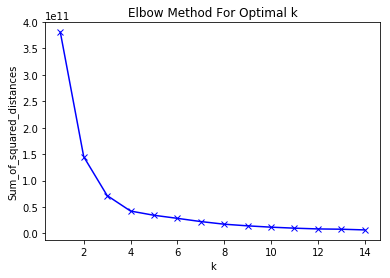

In [106]:
from matplotlib import pyplot as plt

plot = plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')

plot

### So looking at the curve either 4, 6, or 8 make sense. We'll go in the middle and take 6.

In [88]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(MSP_grouped_clustering2)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([5, 1, 1, 1, 1, 3, 3, 0, 1, 5], dtype=int32)

### Add those cluster labels into the dataframe.

In [89]:
# neighborhoods_venues_sorted.drop('Cluster Labels', 1, inplace = True);

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

MSP_merged = MSP_Ranked1

# merge MSP_grouped with MSP_data to add latitude/longitude for each neighborhood
MSP_merged = MSP_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

MSP_merged.head() # check the last columns!

,household_size,total_population,share_population_under18,walkscore,median_household_income,median_home_value,school_per_capita,school_rank,church_per_capita,church_rank,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"Nicollet Island-East Bank, Minneapolis",1.612577,1309.0,0.108108,95,84297.0,257800.0,0.034377,4.0,0.037433,4.0,...,Park,Hot Dog Joint,Music Venue,Liquor Store,Sushi Restaurant,Boutique,Breakfast Spot,Furniture / Home Store,Sports Bar,Spa
"St. Anthony West, Minneapolis",1.875751,2243.0,0.207780,79,84297.0,257800.0,0.019171,7.0,0.020954,8.0,...,Park,Food Truck,Bus Station,Dance Studio,Farmers Market,Middle Eastern Restaurant,Food Court,Fondue Restaurant,Food,Food & Drink Shop
"Downtown East, Minneapolis",1.629117,1254.0,0.110879,90,52736.0,241000.0,0.043062,2.0,0.049442,3.0,...,Theater,Hotel,Bar,American Restaurant,Japanese Restaurant,Seafood Restaurant,Beer Store,Brewery,Sports Club,Sporting Goods Shop
"Sheridan, Minneapolis",2.138639,2884.0,0.316636,82,84297.0,257800.0,0.013176,16.0,0.015603,16.0,...,Dive Bar,American Restaurant,Bar,Performing Arts Venue,Art Gallery,Steakhouse,Movie Theater,Building,Brewery,Fish & Chips Shop
"Bottineau, Minneapolis",2.562074,1656.0,0.416952,66,84297.0,257800.0,0.018720,8.0,0.024155,7.0,...,Harbor / Marina,Vietnamese Restaurant,Steakhouse,Building,Garden Center,Grocery Store,Theme Restaurant,Coffee Shop,Liquor Store,Scenic Lookout


## Need to add the lat and long back in to the MSP_merged dataframe

In [90]:
MSP_merged = MSP_merged.join(TwinCityNeighborhoodsDF[['neighborhood', 'latitude','longitude']].set_index('neighborhood'), on='Neighborhood')

MSP_merged['neighborhood'] = MSP_merged.index # Need to make the index a factor again...

MSP_Ranked['neighborhood'] = MSP_Ranked.index # Need to make the index a factor again...

MSP_merged = MSP_merged.join(MSP_Ranked[['mn_nice_score', 'neighborhood']], on='neighborhood', how = 'left', lsuffix='_left', rsuffix='_right')

MSP_merged['neighborhood'] = MSP_merged.index # Need to make the index a factor again...

MSP_merged['mn_nice_score'] = MSP_merged['mn_nice_score_right']

MSP_merged.drop(['mn_nice_score_right'], axis = 1, inplace = True)

MSP_merged.head() # check the last columns!


,household_size,total_population,share_population_under18,walkscore,median_household_income,median_home_value,school_per_capita,school_rank,church_per_capita,church_rank,...,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,latitude,longitude,neighborhood_left,neighborhood_right,neighborhood,mn_nice_score
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"Nicollet Island-East Bank, Minneapolis",1.612577,1309.0,0.108108,95,84297.0,257800.0,0.034377,4.0,0.037433,4.0,...,Breakfast Spot,Furniture / Home Store,Sports Bar,Spa,44.989073,-93.254010,"Nicollet Island-East Bank, Minneapolis","Nicollet Island-East Bank, Minneapolis","Nicollet Island-East Bank, Minneapolis",0.921569
"St. Anthony West, Minneapolis",1.875751,2243.0,0.207780,79,84297.0,257800.0,0.019171,7.0,0.020954,8.0,...,Food Court,Fondue Restaurant,Food,Food & Drink Shop,44.993244,-93.260348,"St. Anthony West, Minneapolis","St. Anthony West, Minneapolis","St. Anthony West, Minneapolis",0.859477
"Downtown East, Minneapolis",1.629117,1254.0,0.110879,90,52736.0,241000.0,0.043062,2.0,0.049442,3.0,...,Beer Store,Brewery,Sports Club,Sporting Goods Shop,44.975911,-93.254587,"Downtown East, Minneapolis","Downtown East, Minneapolis","Downtown East, Minneapolis",0.848856
"Sheridan, Minneapolis",2.138639,2884.0,0.316636,82,84297.0,257800.0,0.013176,16.0,0.015603,16.0,...,Movie Theater,Building,Brewery,Fish & Chips Shop,45.002404,-93.266446,"Sheridan, Minneapolis","Sheridan, Minneapolis","Sheridan, Minneapolis",0.826797
"Bottineau, Minneapolis",2.562074,1656.0,0.416952,66,84297.0,257800.0,0.018720,8.0,0.024155,7.0,...,Theme Restaurant,Coffee Shop,Liquor Store,Scenic Lookout,45.008185,-93.268369,"Bottineau, Minneapolis","Bottineau, Minneapolis","Bottineau, Minneapolis",0.808824


# Results (2) Now here we get to map out how the neighborhoods are clustered!

In [91]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(MSP_merged['latitude'], MSP_merged['longitude'], MSP_merged['neighborhood'], MSP_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## OK, let's export the merged dataframe with cluster labels as a csv for further analyses.

In [93]:
# Save dataframe as csv file to storage
project.save_data(data=MSP_merged.to_csv(index=False),file_name='MSP_Analyzed.csv',overwrite=True)


{'file_name': 'MSP_Analyzed.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'minnesotanice-donotdelete-pr-m1b1j2ihuwlryd',
 'asset_id': 'f0f5c6ae-b607-4dd2-9864-36e5fa0b8706'}

## Reading it back in now!

In [94]:
body = client_a28f8de00eed48e5bb907b36c94b68c9.get_object(Bucket='minnesotanice-donotdelete-pr-m1b1j2ihuwlryd',Key='MSP_Analyzed.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

MSP_Analyzed_DF = pd.read_csv(body)
MSP_Analyzed_DF.head()

,household_size,total_population,share_population_under18,walkscore,median_household_income,median_home_value,school_per_capita,school_rank,church_per_capita,church_rank,...,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,latitude,longitude,neighborhood_left,neighborhood_right,neighborhood,mn_nice_score
0,1.612577,1309.0,0.108108,95,84297.0,257800.0,0.034377,4.0,0.037433,4.0,...,Breakfast Spot,Furniture / Home Store,Sports Bar,Spa,44.989073,-93.254010,"Nicollet Island-East Bank, Minneapolis","Nicollet Island-East Bank, Minneapolis","Nicollet Island-East Bank, Minneapolis",0.921569
1,1.875751,2243.0,0.207780,79,84297.0,257800.0,0.019171,7.0,0.020954,8.0,...,Food Court,Fondue Restaurant,Food,Food & Drink Shop,44.993244,-93.260348,"St. Anthony West, Minneapolis","St. Anthony West, Minneapolis","St. Anthony West, Minneapolis",0.859477
2,1.629117,1254.0,0.110879,90,52736.0,241000.0,0.043062,2.0,0.049442,3.0,...,Beer Store,Brewery,Sports Club,Sporting Goods Shop,44.975911,-93.254587,"Downtown East, Minneapolis","Downtown East, Minneapolis","Downtown East, Minneapolis",0.848856
3,2.138639,2884.0,0.316636,82,84297.0,257800.0,0.013176,16.0,0.015603,16.0,...,Movie Theater,Building,Brewery,Fish & Chips Shop,45.002404,-93.266446,"Sheridan, Minneapolis","Sheridan, Minneapolis","Sheridan, Minneapolis",0.826797
4,2.562074,1656.0,0.416952,66,84297.0,257800.0,0.018720,8.0,0.024155,7.0,...,Theme Restaurant,Coffee Shop,Liquor Store,Scenic Lookout,45.008185,-93.268369,"Bottineau, Minneapolis","Bottineau, Minneapolis","Bottineau, Minneapolis",0.808824


## Now let's print the top ten of each of the 6 clusters

In [96]:
MSP_Analyzed_DF_top10 = MSP_Analyzed_DF[['neighborhood', 'latitude', 'longitude', 'mn_nice_score', 'Cluster Labels']]

MSP_Analyzed_DF_top10.head()

,neighborhood,latitude,longitude,mn_nice_score,Cluster Labels
0,"Nicollet Island-East Bank, Minneapolis",44.989073,-93.254010,0.921569,3
1,"St. Anthony West, Minneapolis",44.993244,-93.260348,0.859477,3
2,"Downtown East, Minneapolis",44.975911,-93.254587,0.848856,4
3,"Sheridan, Minneapolis",45.002404,-93.266446,0.826797,3
4,"Bottineau, Minneapolis",45.008185,-93.268369,0.808824,3


# Results (3) Map of the top ten MN Nice neighborhoods

In [97]:
MSP_Analyzed_DF_top10_top  = MSP_Analyzed_DF_top10.sort_values(by = 'mn_nice_score', ascending = False).head(10)
MSP_Analyzed_DF_top10_top

,neighborhood,latitude,longitude,mn_nice_score,Cluster Labels
0,"Nicollet Island-East Bank, Minneapolis",44.989073,-93.254010,0.921569,3
1,"St. Anthony West, Minneapolis",44.993244,-93.260348,0.859477,3
2,"Downtown East, Minneapolis",44.975911,-93.254587,0.848856,4
3,"Sheridan, Minneapolis",45.002404,-93.266446,0.826797,3
4,"Bottineau, Minneapolis",45.008185,-93.268369,0.808824,3
5,"Field, Minneapolis",44.914844,-93.269679,0.792484,5
6,"Page, Minneapolis",44.907843,-93.269679,0.776144,5
7,"North Loop, Minneapolis",44.984199,-93.283589,0.772059,3
8,"East Isles, Minneapolis",44.955947,-93.300271,0.770425,0
9,"West Calhoun, Minneapolis",44.944701,-93.326300,0.746732,5


In [98]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(MSP_Analyzed_DF_top10_top['latitude'], MSP_Analyzed_DF_top10_top['longitude'], MSP_Analyzed_DF_top10_top['neighborhood'], MSP_Analyzed_DF_top10_top['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1.0).add_to(map_clusters)
       
map_clusters

# Results (4) Let's print the top ten of each neighborhood in the clusters.

In [102]:
for cluster in MSP_Analyzed_DF_top10['Cluster Labels'] :
    temp = MSP_Analyzed_DF_top10.loc[MSP_Analyzed_DF_top10['Cluster Labels'] == cluster]
    temp = temp.sort_values(by = 'mn_nice_score', ascending = False)
    temp = temp[['neighborhood','mn_nice_score','Cluster Labels']]
    print(temp.head(10))

                              neighborhood  mn_nice_score  Cluster Labels
0   Nicollet Island-East Bank, Minneapolis       0.921569               3
1            St. Anthony West, Minneapolis       0.859477               3
3                    Sheridan, Minneapolis       0.826797               3
4                   Bottineau, Minneapolis       0.808824               3
7                  North Loop, Minneapolis       0.772059               3
17                     Bryant, Minneapolis       0.702614               3
19                     Regina, Minneapolis       0.687908               3
34               East Harriet, Minneapolis       0.583333               3
38                       Hale, Minneapolis       0.571895               3
40                  Keewaydin, Minneapolis       0.567810               3
                              neighborhood  mn_nice_score  Cluster Labels
0   Nicollet Island-East Bank, Minneapolis       0.921569               3
1            St. Anthony West, Minneap

## Now a map of the top ten in each cluster.

### Cluster 0

In [103]:
MSP_Analyzed_DF_top10_top0  = MSP_Analyzed_DF_top10.loc[MSP_Analyzed_DF_top10['Cluster Labels'] == 0].sort_values(by = 'mn_nice_score', ascending = False).head(10)

# create map of the Twin Cities using latitude and longitude values
map_msp = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(MSP_Analyzed_DF_top10_top0['latitude'], MSP_Analyzed_DF_top10_top0['longitude'], MSP_Analyzed_DF_top10_top0['neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[0-1],
        fill=True,
        fill_color=rainbow[0-1],
        fill_opacity=0.8,
        parse_html=False).add_to(map_msp)  
    
map_msp


### Cluster 1

In [104]:
MSP_Analyzed_DF_top10_top1  = MSP_Analyzed_DF_top10.loc[MSP_Analyzed_DF_top10['Cluster Labels'] == 1].sort_values(by = 'mn_nice_score', ascending = False).head(10)

# create map of the Twin Cities using latitude and longitude values
map_msp = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(MSP_Analyzed_DF_top10_top1['latitude'], MSP_Analyzed_DF_top10_top1['longitude'], MSP_Analyzed_DF_top10_top1['neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[1-1],
        fill=True,
        fill_color=rainbow[1-1],
        fill_opacity=0.8,
        parse_html=False).add_to(map_msp)  
    
map_msp


### Cluster 2

In [105]:
MSP_Analyzed_DF_top10_top2  = MSP_Analyzed_DF_top10.loc[MSP_Analyzed_DF_top10['Cluster Labels'] == 2].sort_values(by = 'mn_nice_score', ascending = False).head(10)

# create map of the Twin Cities using latitude and longitude values
map_msp = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(MSP_Analyzed_DF_top10_top2['latitude'], MSP_Analyzed_DF_top10_top2['longitude'], MSP_Analyzed_DF_top10_top2['neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[2-1],
        fill=True,
        fill_color=rainbow[2-1],
        fill_opacity=0.8,
        parse_html=False).add_to(map_msp)  
    
map_msp

### Cluster 3

In [106]:
MSP_Analyzed_DF_top10_top3  = MSP_Analyzed_DF_top10.loc[MSP_Analyzed_DF_top10['Cluster Labels'] == 3].sort_values(by = 'mn_nice_score', ascending = False).head(10)

# create map of the Twin Cities using latitude and longitude values
map_msp = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(MSP_Analyzed_DF_top10_top3['latitude'], MSP_Analyzed_DF_top10_top3['longitude'], MSP_Analyzed_DF_top10_top3['neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[3-1],
        fill=True,
        fill_color=rainbow[3-1],
        fill_opacity=0.8,
        parse_html=False).add_to(map_msp)  
    
map_msp

### Cluster 4

In [107]:
MSP_Analyzed_DF_top10_top4  = MSP_Analyzed_DF_top10.loc[MSP_Analyzed_DF_top10['Cluster Labels'] == 4].sort_values(by = 'mn_nice_score', ascending = False).head(10)

# create map of the Twin Cities using latitude and longitude values
map_msp = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(MSP_Analyzed_DF_top10_top4['latitude'], MSP_Analyzed_DF_top10_top4['longitude'], MSP_Analyzed_DF_top10_top4['neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[4-1],
        fill=True,
        fill_color=rainbow[4-1],
        fill_opacity=1.0,
        parse_html=False).add_to(map_msp)  
    
map_msp

### Cluster 5

In [108]:
MSP_Analyzed_DF_top10_top5  = MSP_Analyzed_DF_top10.loc[MSP_Analyzed_DF_top10['Cluster Labels'] == 5].sort_values(by = 'mn_nice_score', ascending = False).head(10)

# create map of the Twin Cities using latitude and longitude values
map_msp = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(MSP_Analyzed_DF_top10_top5['latitude'], MSP_Analyzed_DF_top10_top5['longitude'], MSP_Analyzed_DF_top10_top5['neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[5-1],
        fill=True,
        fill_color=rainbow[5-1],
        fill_opacity=0.8,
        parse_html=False).add_to(map_msp)  
    
map_msp

# Conclusions:

1. In this analysis we've determined a top ten 'Minnesota Nice' neighborhoods and mapped them out visually.
2. We've done a cluster analysis of all 102 neighborhoods and found a cluster size of 6 that bins them well.
3. We've found the top ten 'Minnesota Nice' neighborhoods in each of those clusters and mapped them out visually.
4. We've obtained all the requirements the tourism board desired from the data consulting group.
5. Final results will be conveyed in a PowerPoint presentation to the stakeholders.